In [5]:
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.pyplot as plt # Matplotlib for plotting
import folium # map rendering library
from folium.features import DivIcon # markers on maps
import seaborn as sns # additional plotting library Seaborn
# Shapely library to check if a venue is inside the city
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

print('Libraries imported.')

Libraries imported.


In [6]:
# constants
geodata_path = "./data/frankfurt.geojson" # path to geojson file
frankfurt_lat = 50.11552 # latitude of Frankfurt
frankfurt_lng = 8.7 # longitude of Frankfurt

# Population Data

First, we get data about the population of Frankfurt. The German Wikipedia page contains a preformatted table which can be easily read with pandas. The original can be found here: https://www.frankfurt.de/sixcms/media.php/738/01_Bev%C3%B6lkerung_Ende2018.pdf

In [60]:
# read wikipedia table into dataframe
df_census = pd.read_html('https://de.wikipedia.org/wiki/Liste_der_Stadtteile_von_Frankfurt_am_Main',
                  decimal=',',
                  thousands='.',
                  flavor='bs4')[0]
print(df_census.shape)
df_census

(47, 13)


,Nr.,Stadtteil,Fläche[3]in km²,Einwohner,Weiblich,Männlich,Deutsche,Ausländer,Ausländerin Prozent,Einwohnerje km²,Ortsbezirk,Stadtteilseit,Vorherige Zugehörigkeit
0,1,Altstadt,0.506,4151,2015,2136,2604,1547,37.3,8204,01 Innenstadt I,1866[Anm. 1],Freie Stadt Frankfurt
1,2,Innenstadt,1.491,6605,3088,3517,3514,3091,46.8,4430,01 Innenstadt I,1866[Anm. 2],Freie Stadt Frankfurt
2,3,Bahnhofsviertel,0.542,3561,1378,2183,1638,1923,54,6570,01 Innenstadt I,1866[Anm. 3],Freie Stadt Frankfurt
3,4,Westend-Süd,2.497,18822,9593,9229,13655,5167,27.5,7538,02 Innenstadt II,1866[Anm. 3],Freie Stadt Frankfurt
4,5,Westend-Nord,1.632,10198,5321,4877,7214,2984,29.3,6249,02 Innenstadt II,1866[Anm. 3],Freie Stadt Frankfurt
5,6,Nordend-West,3.100,30518,15625,14893,23744,6774,22.2,9845,03 Innenstadt III,1866[Anm. 3],Freie Stadt Frankfurt
6,7,Nordend-Ost,1.532,23028,11947,11081,17863,5165,22.4,15031,03 Innenstadt III,1866[Anm. 3],Freie Stadt Frankfurt
7,8,Ostend,5.564,29171,14980,14191,20802,8369,28.7,5243,04 Bornheim/Ostend,1866[Anm. 3],Freie Stadt Frankfurt
8,9,Bornheim,2.786,30533,16110,14423,23214,7319,24,10959,04 Bornheim/Ostend,1877,Stadtkreis Frankfurt am Main[Anm. 4]
9,10,Gutleutviertel,1.792,6924,3027,3897,3976,2948,42.6,3864,01 Innenstadt I,1866[Anm. 3],Freie Stadt Frankfurt


There is one row for each district in Frankfurt and another one for the whole city. In addition, the *Flughafen* district does not contain its own data, but it is included in the row for *Sachsenhausen-Süd*. The DataFrame now has to be cleaned in the following ways:
1. Remove unimportant columns
2. Remove summary row
3. Rename columns to English names
4. Copy missing data from *Sachsenhausen-Süd* to *Flughafen*
5. Set data types to numeric data types

In [61]:
# Remove unimportant columns
df_census.drop(["Nr.", "Vorherige Zugehörigkeit", "Ortsbezirk", "Stadtteilseit"], axis=1, inplace=True)
# Remove sumary row
df_census.drop([46], inplace=True)

In [62]:
# Rename columns to English names
df_census.rename(columns={"Stadtteil": "District",
                   "Fläche[3]in km²": "Area in square km",
                   "Einwohner": "Inhabitants",
                   "Weiblich": "Female",
                   "Männlich": "Male",
                   "Deutsche": "Germans",
                   "Ausländer": "Foreigners",
                   "Ausländerin Prozent": "Foreigners in percent",
                   "Einwohnerje km²": "Inhabitants per square km",
                   "Ortsbezirk": "Area District"},
            inplace=True)

# increment index in order to have it be equal to the Number column in the original data
df_census.index += 1

In [63]:
# Copy missing data from Sachsenhausen-Süd to Flughafen
df_census.loc[15, "Inhabitants"] = df_census.loc[14, "Inhabitants"]
df_census.loc[15, "Female"] = df_census.loc[14, "Female"]
df_census.loc[15, "Male"] = df_census.loc[14, "Male"]
df_census.loc[15, "Germans"] = df_census.loc[14, "Germans"]
df_census.loc[15, "Foreigners"] = df_census.loc[14, "Foreigners"]
df_census.loc[15, "Foreigners in percent"] = df_census.loc[14, "Foreigners in percent"]
df_census.loc[15, "Inhabitants per square km"] = df_census.loc[14, "Inhabitants per square km"]

In [64]:
# Set data types to numeric data types
df_census = df.astype({"Inhabitants": "int32",
           "Female": "int32",
           "Male": "int32",
           "Germans": "int32",
           "Foreigners": "int32",
           "Foreigners in percent": "float32",
           "Inhabitants per square km": "int32"})

In [67]:
print(df_census.shape)
df_census.head()

(46, 9)


,District,Area in square km,Inhabitants,Female,Male,Germans,Foreigners,Foreigners in percent,Inhabitants per square km
1,Altstadt,0.506,4151,2015,2136,2604,1547,37.299999,8204
2,Innenstadt,1.491,6605,3088,3517,3514,3091,46.799999,4430
3,Bahnhofsviertel,0.542,3561,1378,2183,1638,1923,54.000000,6570
4,Westend-Süd,2.497,18822,9593,9229,13655,5167,27.500000,7538
5,Westend-Nord,1.632,10198,5321,4877,7214,2984,29.299999,6249


# Geodata

The second part of the data is a GeoJSON file which contains the borders of each district. Theses borders can be used to assign each venue we find later to one of the districts. The original file can be found here: https://github.com/codeforamerica/click_that_hood/blob/master/public/data/frankfurt-main.geojson

In [68]:
with open(geodata_path) as json_file:
    geo_data = json.load(json_file)

So far we have no information about where each district center is located. In order to find rough estimates for each district center, the minimum *latitude/longitude* and maximum *latitude/longitude* is searched and the halfway point between those values is used.

In [69]:
# find a district by finding the halfway point between min/max lat/long
def find_district_center(coordinates):
    # each lat/long is roughly around 8.6/50.0 so initialization is appropriate
    min_lng = 99
    min_lat = 99
    max_lng = 0
    max_lat = 0
    
    # each point in shape is checked
    for lng, lat in coordinates:
        if lng > max_lng:
            max_lng = lng
        elif lng < min_lng:
            min_lng = lng
            
        if lat > max_lat:
            max_lat = lat
        elif lat < min_lat:
            min_lat = lat
    
    # calculate half way point between min and max
    center_lng = min_lng + ((max_lng - min_lng) / 2);
    center_lat = min_lat + ((max_lat - min_lat) / 2);
    
    return center_lng, center_lat

In [70]:
# interate over all district shapes in the GeoJSON file
for district in geo_data["features"]:
    # get name and shape of current district
    name = district["properties"]["name"]
    shape_of_district = district["geometry"]["coordinates"][0][0]
    
    #calculate district center
    lng, lat = find_district_center(shape_of_district)
    
    # add the calculated lat/long to the dataframe
    df_census.loc[df['District'] == name, "Lat"] = lat
    df_census.loc[df['District'] == name, "Lng"] = lng

In [71]:
print(df_census.shape)
df_census

(46, 11)


,District,Area in square km,Inhabitants,Female,Male,Germans,Foreigners,Foreigners in percent,Inhabitants per square km,Lat,Lng
1,Altstadt,0.506,4151,2015,2136,2604,1547,37.299999,8204,50.110590,8.681539
2,Innenstadt,1.491,6605,3088,3517,3514,3091,46.799999,4430,50.112817,8.682205
3,Bahnhofsviertel,0.542,3561,1378,2183,1638,1923,54.000000,6570,50.107810,8.667658
4,Westend-Süd,2.497,18822,9593,9229,13655,5167,27.500000,7538,50.117950,8.661165
5,Westend-Nord,1.632,10198,5321,4877,7214,2984,29.299999,6249,50.129776,8.666019
6,Nordend-West,3.100,30518,15625,14893,23744,6774,22.200001,9845,50.130401,8.685188
7,Nordend-Ost,1.532,23028,11947,11081,17863,5165,22.400000,15031,50.127570,8.697659
8,Ostend,5.564,29171,14980,14191,20802,8369,28.700001,5243,50.116220,8.721066
9,Bornheim,2.786,30533,16110,14423,23214,7319,24.000000,10959,50.132859,8.711984
10,Gutleutviertel,1.792,6924,3027,3897,3976,2948,42.599998,3864,50.097505,8.645433


Now, that we have estimates for the city center, let's show their locations on a map.

In [255]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11
)

# add a choropleth map showing the population of each district
folium.Choropleth(
    geo_data=geodata_path,
    name='choropleth',
    data=df_census,
    columns=['District', 'Inhabitants'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='Population'
).add_to(m)

# print the district number at the estimated city center
for index, row in df_census.iterrows():
    lng = row["Lng"]
    lat = row["Lat"]
    html = '<div style="font-size: 12pt; color: black;">' + str(index) + '</div>'
    
    folium.Marker([lat, lng], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=html,
        )).add_to(m)
    
m

In [75]:
# save dataframe to storage
# df_census.to_csv("./data/df_census.csv", encoding='utf-8', index=False)

# Find venues with Foursquare

We now start using the Foursquare API to get venue information. We will use the `GET https://api.foursquare.com/v2/venues/search`endpoint of the API which returns a list of venues near a location. There are 5 cuisines we want to search for. Namely, German, Turkish, Italian, Greek and Chinese. We will query the API a total of 230 times, once for each `DISTRICT x CUISINE` combination.

In [76]:
CLIENT_ID = None # removed before publishing
CLIENT_SECRET = None # removed before publishing
VERSION = '20180605' # Foursquare API version

In [116]:
LIMIT = 500 # limit of number of venues returned by Foursquare API

radius = 3000 # define radius

# the values in the dict correspond to the category ID for the Foursquare API
cuisines = {"DE": "4bf58dd8d48988d10d941735",
            "TR": "4f04af1f2fb6e1c99f3db0bb",
            "IT": "4bf58dd8d48988d110941735",
            "GR": "4bf58dd8d48988d10e941735",
            "CN": "4bf58dd8d48988d145941735"}

In [79]:
results = {"DE" : [],
           "TR" : [],
           "IT" : [],
           "GR" : [],
           "CN" : []}

for cuisine_country, cuisine_api_id in cuisines.items():
    for index, row in df_census.iterrows():

        district_lng = row["Lng"]
        district_lat = row["Lat"]
        
        # one query for each district and cuisine combination with a max radius of 3000 meters
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                district_lat, 
                district_lng, 
                radius, 
                LIMIT,
                cuisine_api_id)
        
        #send API request
        #results[cuisine_country].append(requests.get(url).json())

In [215]:
num_venues = 0

for cuisine in cuisines.keys():
    for district in results[cuisine]:
        num_venues += len(district["response"]["venues"])
        
num_venues

5894

The API has returned 5894 results. As some districts are very close to each other, it is inevitable that duplicate entries exist. The next step is to clean the data and create a DataFrame.

In [236]:
def create_dataframe(cuisine):
    venues = None
    
    # iterate over districts and create a raw dataframe
    for i, district in enumerate(results[cuisine]):
        if venues is not None:
            venues = venues.append(json_normalize(district["response"]["venues"]))
        else:
            venues = json_normalize(district["response"]['venues'])
            
    # only keep relevant info
    venues = venues[['name', 'id', 'location.address', 'location.lat', 'location.lng']]
    # rename columns
    venues.columns = ['Name', 'ID','Address', 'Lat', 'Lng']
    # drop duplicate rows
    venues = venues.drop_duplicates()
    # add info about served cuisine
    venues["Cuisine"] = cuisine
    
    return venues

In [237]:
df_venues = None

for cuisine in cuisines.keys():
    if df_venues is not None:
        df_venues = df_venues.append(create_dataframe(cuisine))
    else:
        df_venues = create_dataframe(cuisine)
        
df_venues.reset_index(drop=True, inplace=True)

In [238]:
print(df_venues.shape)
print(df_venues.groupby("Cuisine").count()["Name"])
df_venues.head()

(1056, 6)
Cuisine
CN     86
DE    349
GR    100
IT    302
TR    219
Name: Name, dtype: int64


,Name,ID,Address,Lat,Lng,Cuisine
0,Zum Standesämtchen,4c3b6d08def90f470beefd2d,Römerberg 23,50.110296,8.682389,DE
1,Wirtshaus am Hühnermarkt,5c180459a4b51b002c093a70,Markt 16-18,50.110777,8.684000,DE
2,Frankfurter Wirtshaus,5b3225a7e65d0c002c94296b,Mainkai 35,50.109050,8.681975,DE
3,Max on One,4e9dc4dff5b95ad93faa8788,Thurn-und-Taxis-Platz 2,50.115110,8.680233,DE
4,Heimat – Essen und Weine,4cfd2a882c1aa090410e057a,Berliner Str. 70,50.111125,8.678286,DE


The new `df_venues` dataframe now has 1056 unique entries. Each cuisine has the following count:

German: 349

Turkish: 219

Italian: 302

Greek: 100

Chinese: 86

Let us see where they are located on the map.

In [256]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11  # Limited levels of zoom for free Mapbox tiles.
)

# add district borders
folium.GeoJson(
    geodata_path,
    name='geojson'
).add_to(m)

# define individual colors for each cuisine
colors = {"DE": "red",
          "TR": "blue",
          "IT": "green",
          "GR": "purple",
          "CN": "orange"}

# place a marker on the map for each found venue
for index, row in df_venues.iterrows():
    lat = row["Lat"]
    lng = row["Lng"]
    label = row["Name"]
    color = colors[row["Cuisine"]]
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(m)

# add a legend to the map
legend_html =   '''
                <div style="position: fixed;
                            background: black;
                            opacity: 0.7;
                            color: white;
                            bottom: 350px; left: 200px; width: 100px; height: 150px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Cuisines <br><br>
                              &nbsp; <i class="fa fa-circle-o " style="color:red"></i> &nbsp; German<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:blue"></i> &nbsp; Turkish<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:green"></i> &nbsp; Italian<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:purple"></i> &nbsp; Greek<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:orange"></i> &nbsp; Chinese
                </div>
                ''' 
m.get_root().html.add_child(folium.Element(legend_html))

m

Due to the radius setting in the query, the results also contain venues which are outside of Frankfurt. We are now going to filter those out with the `shapely` library.

Each district in the GeoJSON file consists of multiple points. These points define a polygon. We now convert these polygons to a `shapely.Polygon`

In [240]:
polygons = []
district_polygons = {}

# convert each district to a shapely Polygon and save them in a dict:
# "district name": Polygon
for district in geo_data["features"]:
    district_name = district["properties"]["name"]
    
    shape_of_district = district["geometry"]["coordinates"][0][0]
    points = [(p[0], p[1]) for p in shape_of_district]
    district_polygon = Polygon(points)
    
    district_polygons[district_name] = district_polygon

In [253]:
# check whether a point is within a polygon
# i.e. echeck whether a venue(lng, lat) is inside a district(list(lng,lat))
# returns "None" if it is not within a district of Frankfurt
def is_within_borders(point, polygons):
    for name, polygon in district_polygons.items():
        if polygon.contains(point):
            return name
        
    return "None"

In [254]:
# Create a mask which shows which venues are within the borders of Frankfurt
keep_mask = []

for index, row in df_venues.iterrows():
    point = Point(row["Lng"], row["Lat"])
    keep_mask.append(is_within_borders(point, district_polygons))

In [256]:
# apply the mask to the "District" column
df_venues["District"] = keep_mask
# drop all rows which are tagged "None"
df_venues = df_venues[df_venues["District"] != "None"]

In [265]:
df_venues.shape

(825, 7)

The filtered DataFrame now contains only 825 venues. Let's see the effect of the filtering on the map.

In [193]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11  # Limited levels of zoom for free Mapbox tiles.
)

# add district borders
folium.GeoJson(
    geodata_path,
    name='geojson'
).add_to(m)

# define individual colors for each cuisine
colors = {"DE": "red",
          "TR": "blue",
          "IT": "green",
          "GR": "purple",
          "CN": "orange"}

# place a marker on the map for each found venue
for index, row in df_venues.iterrows():
    lat = row["Lat"]
    lng = row["Lng"]
    label = row["Name"]
    color = colors[row["Cuisine"]]
    
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(m)

# add a legend to the map
legend_html =   '''
                <div style="position: fixed;
                            background: black;
                            opacity: 0.7;
                            color: white;
                            bottom: 350px; left: 200px; width: 100px; height: 150px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Cuisines <br><br>
                              &nbsp; <i class="fa fa-circle-o " style="color:red"></i> &nbsp; German<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:blue"></i> &nbsp; Turkish<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:green"></i> &nbsp; Italian<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:purple"></i> &nbsp; Greek<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:orange"></i> &nbsp; Chinese
                </div>
                ''' 
m.get_root().html.add_child(folium.Element(legend_html))

m

Indeed, the `df_venues` DataFrame now only contains venues which are within the borders.

In [262]:
# save dataframe to storage
# df_venues.to_csv("./data/df_venues.csv", encoding="utf-8", index=False)

# Get venue details with Foursquare

Now, we want to use the Foursquare API to get details for all the venues we have found so far. We use the `GET https://api.foursquare.com/v2/venues/VENUE_ID` endpoint for that.

In [351]:
CLIENT_ID = None # Removed before publishing
CLIENT_SECRET = None # Removed before publishing
VERSION = '20180605' # Foursquare API version

In [363]:
all_venue_details = []

for venue_id in df_venues["ID"]:
    
    # construct a URL with each venue id
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(
                venue_id,
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION 
                )
    # send API request
    #all_venue_details.append(requests.get(url).json())

In [372]:
df_details = None

# iterate over all the query results
for venue in all_venue_details:
    # a status code of 200 means the query was successful
    if venue["meta"]["code"] == 200:
        info = json_normalize(venue['response']['venue'])

        if df_details is not None:
            df_details = df_details.append(info)
        else:
            df_details = info

# only keep relevant columns
df_details = df_details[["id", "likes.count", "listed.count", "photos.count", "price.tier", "rating", "ratingSignals", "tips.count"]]
# rename columns
df_details.columns = ['ID', 'Likes','Listed', 'Photos', 'Price', 'Rating', 'Rating Signals', 'Tips']
# reset index
df_details = df_details.reset_index(drop=True)

In [376]:
print(df_details.shape)
df_details.head()

(825, 8)


,ID,Likes,Listed,Photos,Price,Rating,Rating Signals,Tips
0,4c3b6d08def90f470beefd2d,25.0,5,86,2.0,6.1,60.0,19
1,5c180459a4b51b002c093a70,2.0,1,4,2.0,NaN,NaN,1
2,5b3225a7e65d0c002c94296b,7.0,1,10,2.0,5.5,21.0,6
3,4e9dc4dff5b95ad93faa8788,16.0,15,44,2.0,8.6,17.0,3
4,4cfd2a882c1aa090410e057a,43.0,136,49,2.0,8.7,59.0,16


The resulting DataFrame has one entry for each venue. With that we conclude the data collection.

In [358]:
# save DataFrame to storage
# df_details.to_csv("./data/df_details.csv", encoding="utf-8", index=False)

# Analysis

In [7]:
df_census = pd.read_csv("./data/df_census.csv", encoding="utf-8")
df_venues = pd.read_csv("./data/df_venues.csv", encoding='utf-8')
df_details = pd.read_csv("./data/df_details.csv", encoding="utf-8")
print("Data loaded.")

Data loaded.


In [8]:
print(df_census.shape)
df_census.head()

(46, 11)


,District,Area in square km,Inhabitants,Female,Male,Germans,Foreigners,Foreigners in percent,Inhabitants per square km,Lat,Lng
0,Altstadt,0.506,4151,2015,2136,2604,1547,37.3,8204,50.110590,8.681539
1,Innenstadt,1.491,6605,3088,3517,3514,3091,46.8,4430,50.112817,8.682205
2,Bahnhofsviertel,0.542,3561,1378,2183,1638,1923,54.0,6570,50.107810,8.667658
3,Westend-Süd,2.497,18822,9593,9229,13655,5167,27.5,7538,50.117950,8.661165
4,Westend-Nord,1.632,10198,5321,4877,7214,2984,29.3,6249,50.129776,8.666019


In [9]:
print(df_venues.shape)
df_venues.head()

(825, 7)


,Name,ID,Address,Lat,Lng,Cuisine,District
0,Zum Standesämtchen,4c3b6d08def90f470beefd2d,Römerberg 23,50.110296,8.682389,DE,Altstadt
1,Wirtshaus am Hühnermarkt,5c180459a4b51b002c093a70,Markt 16-18,50.110777,8.684000,DE,Altstadt
2,Frankfurter Wirtshaus,5b3225a7e65d0c002c94296b,Mainkai 35,50.109050,8.681975,DE,Altstadt
3,Max on One,4e9dc4dff5b95ad93faa8788,Thurn-und-Taxis-Platz 2,50.115110,8.680233,DE,Innenstadt
4,Heimat – Essen und Weine,4cfd2a882c1aa090410e057a,Berliner Str. 70,50.111125,8.678286,DE,Altstadt


In [10]:
print(df_details.shape)
df_details.head()

(825, 8)


,ID,Likes,Listed,Photos,Price,Rating,Rating Signals,Tips
0,4c3b6d08def90f470beefd2d,25.0,5,86,2.0,6.1,60.0,19
1,5c180459a4b51b002c093a70,2.0,1,4,2.0,NaN,NaN,1
2,5b3225a7e65d0c002c94296b,7.0,1,10,2.0,5.5,21.0,6
3,4e9dc4dff5b95ad93faa8788,16.0,15,44,2.0,8.6,17.0,3
4,4cfd2a882c1aa090410e057a,43.0,136,49,2.0,8.7,59.0,16


# Analysis of Districts

In [11]:
df_venue_details = pd.merge(df_venues, df_details, on="ID")
df_venue_details.head()

,Name,ID,Address,Lat,Lng,Cuisine,District,Likes,Listed,Photos,Price,Rating,Rating Signals,Tips
0,Zum Standesämtchen,4c3b6d08def90f470beefd2d,Römerberg 23,50.110296,8.682389,DE,Altstadt,25.0,5,86,2.0,6.1,60.0,19
1,Wirtshaus am Hühnermarkt,5c180459a4b51b002c093a70,Markt 16-18,50.110777,8.684000,DE,Altstadt,2.0,1,4,2.0,NaN,NaN,1
2,Frankfurter Wirtshaus,5b3225a7e65d0c002c94296b,Mainkai 35,50.109050,8.681975,DE,Altstadt,7.0,1,10,2.0,5.5,21.0,6
3,Max on One,4e9dc4dff5b95ad93faa8788,Thurn-und-Taxis-Platz 2,50.115110,8.680233,DE,Innenstadt,16.0,15,44,2.0,8.6,17.0,3
4,Heimat – Essen und Weine,4cfd2a882c1aa090410e057a,Berliner Str. 70,50.111125,8.678286,DE,Altstadt,43.0,136,49,2.0,8.7,59.0,16


In [12]:
df_groupby_district = df_venue_details.groupby("District")

In [13]:
df_groupby_district_count = df_groupby_district.count()["Name"].reset_index()
df_groupby_district_count.columns = ["District", "Count"]
df_groupby_district_count["% of total count"] = df_groupby_district_count["Count"] / df_venues.shape[0]
df_groupby_district_count = df_groupby_district_count.sort_values("Count", ascending=False)
df_groupby_district_count["cumsum % of total count"] = df_groupby_district_count["% of total count"].cumsum()
df_groupby_district_count.head()

,District,Count,% of total count,cumsum % of total count
13,Gallus,72,0.087273,0.087273
36,Sachsenhausen-Nord,71,0.086061,0.173333
4,Bockenheim,65,0.078788,0.252121
21,Innenstadt,57,0.069091,0.321212
6,Bornheim,40,0.048485,0.369697


In [58]:
df_groupby_district_count.tail()

,District,Count,% of total count,cumsum % of total count,Count DE,Count TR,Count IT,Count GR,Count CN,Count INT
41,Riederwald,4,0.004848,0.991515,0,1,2,0,1,4
42,Frankfurter Berg,2,0.002424,0.993939,0,1,1,0,0,2
43,Preungesheim,2,0.002424,0.996364,0,0,2,0,0,2
44,Hausen,2,0.002424,0.998788,1,0,0,1,0,1
45,Berkersheim,1,0.001212,1.000000,1,0,0,0,0,0


In [14]:
# create a folium map centered on Frankfurt
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11
)

# add a choropleth map showing the venue density of each district
folium.Choropleth(
    geo_data=geodata_path,
    name='choropleth',
    data=df_groupby_district_count,
    columns=['District', 'Count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=1,
    legend_name='Venue count per district'
).add_to(m)

# print the venue count at the estimated city center
for index, row in df_groupby_district_count.iterrows():
    lng = df_census.loc[df_census["District"] == row["District"], "Lng"]
    lat = df_census.loc[df_census["District"] == row["District"], "Lat"]
    count = row["Count"]
    
    html = '<div style="font-size: 12pt; color: black;">' + str(count) + '</div>'
    
    folium.Marker([lat, lng], icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(7,20),
        html=html,
        )).add_to(m)
    
m

In [15]:
cuisines = ["DE", "TR", "IT", "GR", "CN"]

for cuisine in cuisines:
    venues_for_cuisine = df_venues[df_venues["Cuisine"] == cuisine].groupby("District").count()["Name"].reset_index()
    col_string = "Count " + cuisine
    venues_for_cuisine.columns = ["District", col_string]
    df_groupby_district_count = pd.merge(df_groupby_district_count, venues_for_cuisine, on="District", how="outer")
df_groupby_district_count = df_groupby_district_count.fillna(0)
df_groupby_district_count["Count INT"] = df_groupby_district_count["Count"] - df_groupby_district_count["Count DE"]

# Set data types to integer values
df_groupby_district_count = df_groupby_district_count.astype({
    "Count DE": "int32",
    "Count TR": "int32",
    "Count IT": "int32",
    "Count GR": "int32",
    "Count CN": "int32",
    "Count INT": "int32"
})

In [16]:
# Final count df
df_groupby_district_count.sort_values("Count", ascending=False).head()

,District,Count,% of total count,cumsum % of total count,Count DE,Count TR,Count IT,Count GR,Count CN,Count INT
0,Gallus,72,0.087273,0.087273,11,20,23,9,9,61
1,Sachsenhausen-Nord,71,0.086061,0.173333,33,12,19,3,4,38
2,Bockenheim,65,0.078788,0.252121,17,14,24,6,4,48
3,Innenstadt,57,0.069091,0.321212,14,14,15,6,8,43
4,Bornheim,40,0.048485,0.369697,15,10,9,4,2,25


In [17]:
df_groupby_district_mean = df_venue_details.drop(["Lat", "Lng"], axis=1).groupby("District").mean()
df_groupby_district_mean.columns = ["Avg Likes", "Avg Listed", "Avg Photots", "Avg Price", "Avg Rating", "Avg Rating Signals", "Avg Tips"]
df_groupby_district_mean.reset_index().head()

,District,Avg Likes,Avg Listed,Avg Photots,Avg Price,Avg Rating,Avg Rating Signals,Avg Tips
0,Altstadt,29.575758,25.382353,47.970588,1.866667,6.950000,78.863636,13.117647
1,Bahnhofsviertel,20.090909,10.696970,18.848485,1.714286,6.917647,61.529412,8.090909
2,Bergen-Enkheim,1.772727,0.318182,3.181818,2.000000,6.400000,13.000000,0.681818
3,Berkersheim,7.000000,1.000000,8.000000,2.000000,6.500000,14.000000,4.000000
4,Bockenheim,10.030769,8.846154,6.507692,1.754386,7.100000,38.120000,4.446154


In [18]:
df_groupby_district_merge = pd.merge(df_groupby_district_count, df_groupby_district_mean, on="District")
df_groupby_district_merge.head()

,District,Count,% of total count,cumsum % of total count,Count DE,Count TR,Count IT,Count GR,Count CN,Count INT,Avg Likes,Avg Listed,Avg Photots,Avg Price,Avg Rating,Avg Rating Signals,Avg Tips
0,Gallus,72,0.087273,0.087273,11,20,23,9,9,61,8.638889,6.291667,7.500000,1.759259,6.786364,41.454545,3.861111
1,Sachsenhausen-Nord,71,0.086061,0.173333,33,12,19,3,4,38,29.408451,28.563380,33.408451,1.909091,7.413514,83.918919,12.887324
2,Bockenheim,65,0.078788,0.252121,17,14,24,6,4,48,10.030769,8.846154,6.507692,1.754386,7.100000,38.120000,4.446154
3,Innenstadt,57,0.069091,0.321212,14,14,15,6,8,43,26.631579,16.421053,27.526316,1.829787,7.384615,59.564103,9.105263
4,Bornheim,40,0.048485,0.369697,15,10,9,4,2,25,10.025000,6.425000,6.375000,1.777778,6.968750,35.937500,3.500000


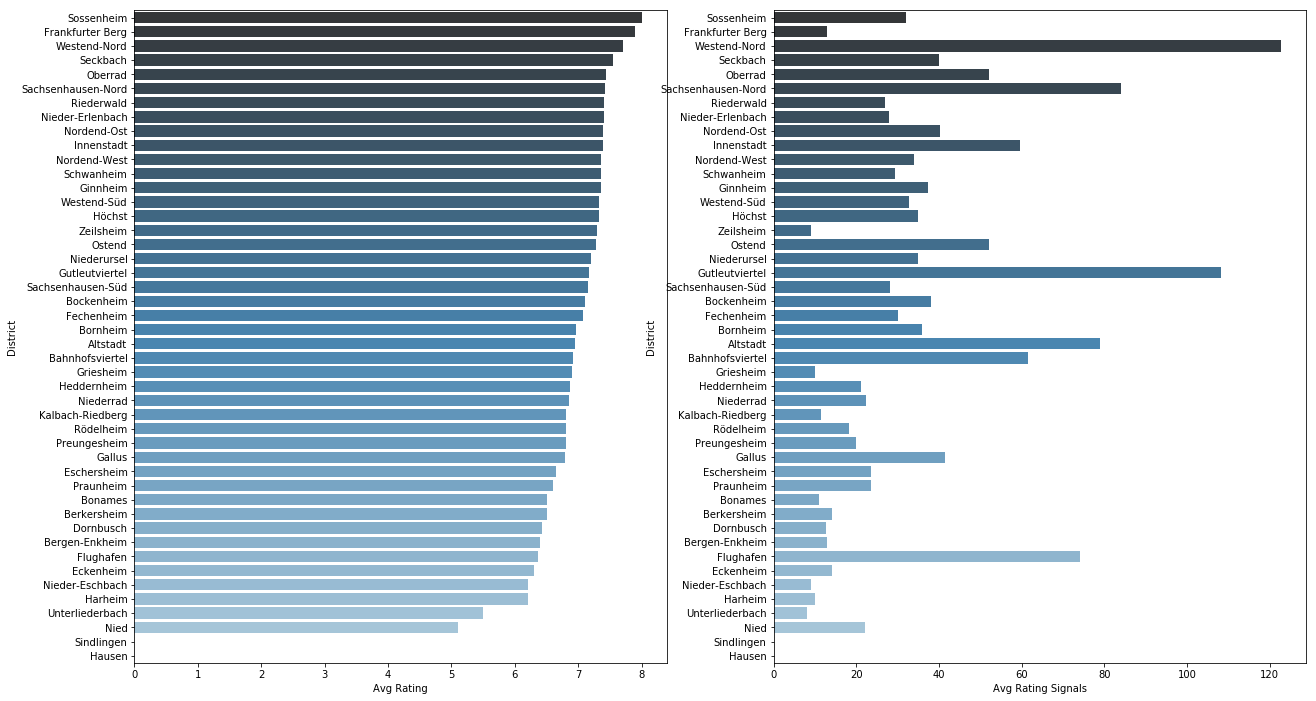

In [59]:
df_groupby_district_merge = df_groupby_district_merge.sort_values("Avg Rating", ascending=False)

fig, axs = plt.subplots(ncols=2, figsize=(21,12), sharey=False)

sns.barplot(x='Avg Rating', y='District', data=df_groupby_district_merge, ax=axs[0], palette="Blues_d")
sns.barplot(x='Avg Rating Signals', y='District', data=df_groupby_district_merge, ax=axs[1], palette="Blues_d")

# Analysis of Cuisines

In [20]:
df_venue_details.head()

,Name,ID,Address,Lat,Lng,Cuisine,District,Likes,Listed,Photos,Price,Rating,Rating Signals,Tips
0,Zum Standesämtchen,4c3b6d08def90f470beefd2d,Römerberg 23,50.110296,8.682389,DE,Altstadt,25.0,5,86,2.0,6.1,60.0,19
1,Wirtshaus am Hühnermarkt,5c180459a4b51b002c093a70,Markt 16-18,50.110777,8.684000,DE,Altstadt,2.0,1,4,2.0,NaN,NaN,1
2,Frankfurter Wirtshaus,5b3225a7e65d0c002c94296b,Mainkai 35,50.109050,8.681975,DE,Altstadt,7.0,1,10,2.0,5.5,21.0,6
3,Max on One,4e9dc4dff5b95ad93faa8788,Thurn-und-Taxis-Platz 2,50.115110,8.680233,DE,Innenstadt,16.0,15,44,2.0,8.6,17.0,3
4,Heimat – Essen und Weine,4cfd2a882c1aa090410e057a,Berliner Str. 70,50.111125,8.678286,DE,Altstadt,43.0,136,49,2.0,8.7,59.0,16


In [21]:
groupby_cuisine_count = df_venue_details.drop(["Lat", "Lng"], axis=1).groupby("Cuisine").count().reset_index()
groupby_cuisine_count = groupby_cuisine_count.drop(["Name", "ID", "Address", "District"], axis=1)
groupby_cuisine_count.columns = ["Cuisine", "Count Likes", "Count Listed", "Count Photos", "Count Price",
                                 "Count Rating", "Count Rating Signals", "Count Tips"]
groupby_cuisine_count

,Cuisine,Count Likes,Count Listed,Count Photos,Count Price,Count Rating,Count Rating Signals,Count Tips
0,CN,68,68,68,66,18,18,68
1,DE,268,269,269,233,134,134,269
2,GR,67,67,67,55,14,14,67
3,IT,250,250,250,236,153,153,250
4,TR,171,171,171,78,32,32,171


In [22]:
groupby_cuisine_avg = df_venue_details.drop(["Lat", "Lng"], axis=1).groupby("Cuisine").mean().reset_index()
groupby_cuisine_avg.columns = ["Cuisine", "Avg Likes", "Avg Listed", "Avg Photos", "Avg Price",
                                 "Avg Rating", "Avg Rating Signals", "Avg Tips"]
groupby_cuisine_avg

,Cuisine,Avg Likes,Avg Listed,Avg Photos,Avg Price,Avg Rating,Avg Rating Signals,Avg Tips
0,CN,5.661765,4.455882,7.044118,1.893939,6.511111,30.611111,2.970588
1,DE,20.317164,14.750929,25.215613,1.952790,7.151493,62.649254,7.646840
2,GR,7.776119,6.059701,6.865672,1.963636,7.564286,50.285714,3.179104
3,IT,18.112000,12.256000,14.784000,1.932203,7.134641,45.366013,7.528000
4,TR,4.619883,1.438596,4.152047,1.051282,6.987500,34.500000,1.988304


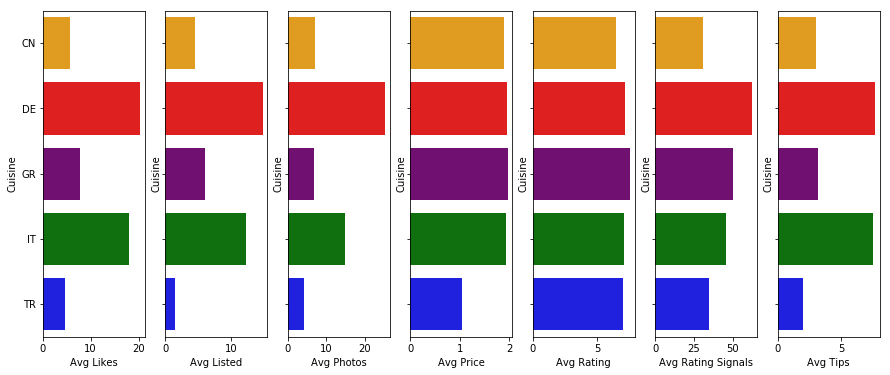

In [23]:
fig, axs = plt.subplots(ncols=7, figsize=(15,6), sharey=True)

color_palette = ["orange", "red", "purple", "green", "blue"]

sns.barplot(x='Avg Likes', y='Cuisine', data=groupby_cuisine_avg, ax=axs[0], palette=color_palette)
sns.barplot(x='Avg Listed', y='Cuisine', data=groupby_cuisine_avg, ax=axs[1], palette=color_palette)
sns.barplot(x='Avg Photos',y='Cuisine', data=groupby_cuisine_avg, ax=axs[2], palette=color_palette)
sns.barplot(x='Avg Price',y='Cuisine', data=groupby_cuisine_avg, ax=axs[3], palette=color_palette)
sns.barplot(x='Avg Rating',y='Cuisine', data=groupby_cuisine_avg, ax=axs[4], palette=color_palette)
sns.barplot(x='Avg Rating Signals',y='Cuisine', data=groupby_cuisine_avg, ax=axs[5], palette=color_palette)
sns.barplot(x='Avg Tips',y='Cuisine', data=groupby_cuisine_avg, ax=axs[6], palette=color_palette)

In [24]:
def distplot_column(column_name, bin_size=10, xlim=None):
    cuisines = ["DE", "TR", "IT", "GR", "CN"]

    colors = {"DE": "red",
          "TR": "blue",
          "IT": "green",
          "GR": "purple",
          "CN": "orange",
          "ALL": "gray"}
    
    
    plt.figure(figsize=(16, 6))
    if xlim is not None:
        plt.xlim(xlim[0], xlim[1])        
    data = df_venue_details[column_name].dropna()
    count = data.shape[0]
    label = "ALL" + " (" + str(count) + ")"

    sns.distplot(data, hist=True, bins=bin_size, label=label, color=colors["ALL"])

    for cuisine in cuisines:
        data = df_venue_details.loc[df_venue_details["Cuisine"] == cuisine, column_name].dropna()
        count = data.shape[0]
        label = cuisine + " (" + str(count) + ")"
        sns.distplot(data, hist=False, kde=True, bins=bin_size, label=label, color=colors[cuisine])

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


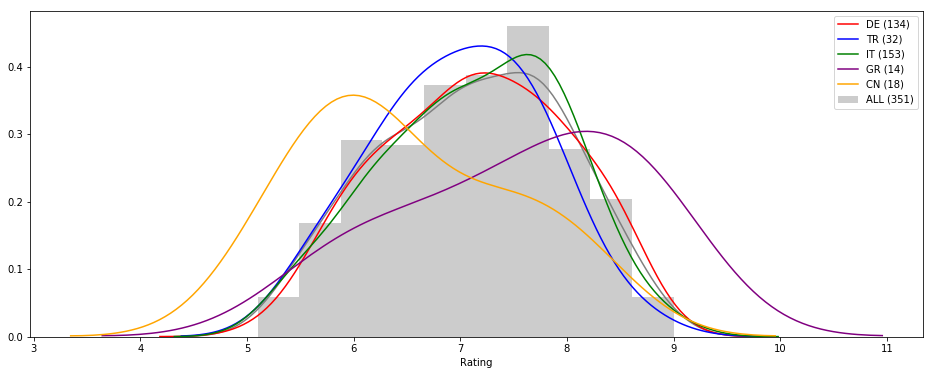

In [25]:
distplot_column("Rating", 10)

In [26]:
census_venues_merge = pd.merge(df_census.drop(["Lat", "Lng", "Inhabitants per square km", "Foreigners in percent"], axis=1),
                               df_groupby_district_count.drop(["% of total count", "cumsum % of total count"], axis=1),
                               on="District")
census_venues_merge.head()

,District,Area in square km,Inhabitants,Female,Male,Germans,Foreigners,Count,Count DE,Count TR,Count IT,Count GR,Count CN,Count INT
0,Altstadt,0.506,4151,2015,2136,2604,1547,34,18,5,5,4,2,16
1,Innenstadt,1.491,6605,3088,3517,3514,3091,57,14,14,15,6,8,43
2,Bahnhofsviertel,0.542,3561,1378,2183,1638,1923,33,4,9,4,0,16,29
3,Westend-Süd,2.497,18822,9593,9229,13655,5167,39,10,2,25,0,2,29
4,Westend-Nord,1.632,10198,5321,4877,7214,2984,7,1,3,3,0,0,6


In [27]:
census_venues_merge_corr = census_venues_merge.corr(method='pearson')

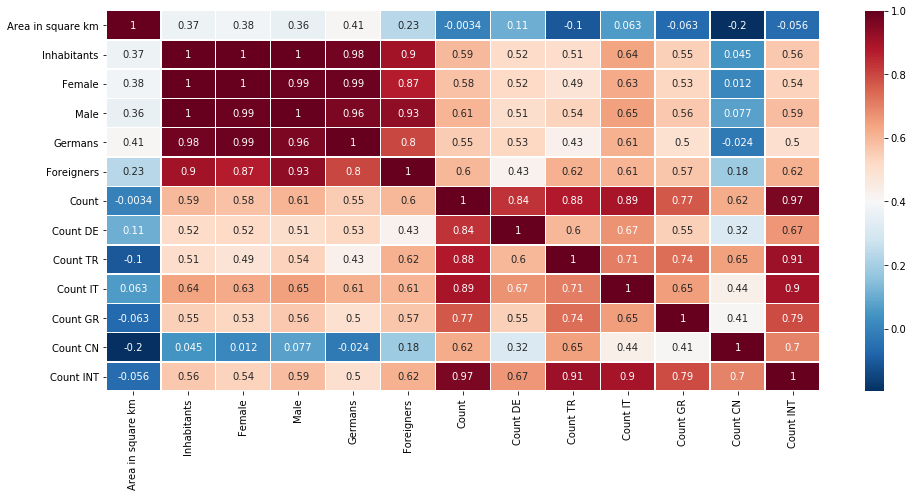

In [28]:
fig, ax = plt.subplots(figsize=(16,7)) 
sns.heatmap(census_venues_merge_corr, 
            xticklabels=census_venues_merge_corr.columns,
            yticklabels=census_venues_merge_corr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5)

In [29]:
census_venues_merge_corr.index

Index(['Area in square km', 'Inhabitants', 'Female', 'Male', 'Germans',
       'Foreigners', 'Count', 'Count DE', 'Count TR', 'Count IT', 'Count GR',
       'Count CN', 'Count INT'],
      dtype='object')

In [30]:
dif_df = census_venues_merge_corr.loc[["Germans", "Foreigners"], ["Count", "Count DE", "Count TR", "Count IT", "Count GR", "Count CN", "Count INT"]]
dif_series = (dif_df.loc["Germans"] - dif_df.loc["Foreigners"])
dif_series.name = "Difference"
dif_df.append(dif_series)

,Count,Count DE,Count TR,Count IT,Count GR,Count CN,Count INT
Germans,0.551441,0.525291,0.430631,0.614693,0.499301,-0.024193,0.503028
Foreigners,0.600077,0.425744,0.615729,0.606550,0.568396,0.183584,0.615326
Difference,-0.048636,0.099547,-0.185098,0.008143,-0.069095,-0.207777,-0.112298


# Analysis of Venues

In [31]:
top10 = df_venue_details.sort_values("Rating", ascending=False).head(10)
bottom10 = df_venue_details.sort_values("Rating", ascending=True).head(10)

In [32]:
top10.drop(["ID"], axis=1)

,Name,Address,Lat,Lng,Cuisine,District,Likes,Listed,Photos,Price,Rating,Rating Signals,Tips
488,Trattoria i Siciliani,Walter-Kolb-Str. 17,50.104896,8.684428,IT,Sachsenhausen-Nord,168.0,179,73,NaN,9.0,296.0,149
695,Omonia,Eckenheimer Landstr. 126,50.127359,8.685447,GR,Nordend-West,40.0,92,16,2.0,8.9,62.0,24
477,da Cimino,Adalbertstr. 29,50.119496,8.645682,IT,Bockenheim,284.0,442,115,2.0,8.9,410.0,112
723,Parthenon Greek Restaurant,Stresemannallee,50.101037,8.674486,GR,Sachsenhausen-Nord,68.0,39,67,2.0,8.8,100.0,28
4,Heimat – Essen und Weine,Berliner Str. 70,50.111125,8.678286,DE,Altstadt,43.0,136,49,2.0,8.7,59.0,16
724,Ariston Restaurant,Heiligkreuzgasse 29,50.115498,8.689205,GR,Innenstadt,99.0,94,67,2.0,8.7,143.0,40
442,Super Bros,Oeder Weg 55-57,50.121681,8.680445,IT,Nordend-West,39.0,59,19,2.0,8.7,52.0,12
29,Manufactum brot&butter,Bockenheimer Anlage 49-50,50.115958,8.670772,DE,Westend-Süd,94.0,160,46,NaN,8.7,119.0,19
271,Emir‘Et,Allerheiligenstr.21,50.113518,8.689303,TR,Innenstadt,14.0,14,17,1.0,8.6,23.0,6
3,Max on One,Thurn-und-Taxis-Platz 2,50.115110,8.680233,DE,Innenstadt,16.0,15,44,2.0,8.6,17.0,3


In [35]:
bottom10.drop(["ID"], axis=1)

,Name,Address,Lat,Lng,Cuisine,District,Likes,Listed,Photos,Price,Rating,Rating Signals,Tips
821,Der Goldene Wok,Mainzer Landstraße 793,50.099010,8.562728,CN,Nied,6.0,4,17,2.0,5.1,22.0,7
71,Zum Schwarzen Stern,Römerberg 6,50.110274,8.682466,DE,Altstadt,21.0,5,75,2.0,5.2,50.0,14
804,Ding Ding Sheng,Moselstr. 23,50.107416,8.667175,CN,Bahnhofsviertel,12.0,12,24,2.0,5.3,31.0,11
585,Italissimo,"Terminal 1, Gate A22",50.046548,8.567226,IT,Flughafen,18.0,4,43,2.0,5.3,43.0,11
623,Ristorante Il Quadrifoglio,NaN,50.150284,8.622023,IT,Praunheim,3.0,0,3,2.0,5.4,8.0,0
670,Fantasia 5,Berger Str. 191,50.125787,8.707198,IT,Bornheim,12.0,2,15,2.0,5.4,25.0,6
781,China Restaurant New World,Am Hauptbahnhof 8,50.107547,8.665013,CN,Bahnhofsviertel,3.0,0,11,1.0,5.4,8.0,1
580,Vito,Frankfurt Airport,50.051985,8.587016,IT,Flughafen,8.0,1,27,2.0,5.4,22.0,3
138,Ludwigs,NaN,50.052068,8.586865,DE,Flughafen,14.0,0,35,2.0,5.5,31.0,8
677,Ristorante Pizzeria Limoncello,NaN,50.107399,8.543978,IT,Unterliederbach,2.0,1,4,2.0,5.5,8.0,4


In [37]:
m = folium.Map(
    location=[frankfurt_lat, frankfurt_lng],
    zoom_start=11  # Limited levels of zoom for free Mapbox tiles.
)

def style_function(feature):
    if feature["properties"]["name"] :
        style = {
            'fillColor': "blue",

            }
    else:
        style = {
            "fillColor": "white"
            }
        
    return style

folium.GeoJson(
    geodata_path,
    name='geojson'
).add_to(m)
    
for index, row in top10.iterrows():

    lat = row["Lat"]
    lng = row["Lng"]
    label = row["Name"]
    color = "blue"

    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(m)
    
for index, row in bottom10.iterrows():

    lat = row["Lat"]
    lng = row["Lng"]
    label = row["Name"]
    color = "red"

    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color=color,
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(m)  
    
# add a legend to the map
legend_html =   '''
                <div style="position: fixed;
                            background: black;
                            opacity: 0.7;
                            color: white;
                            bottom: 350px; left: 200px; width: 100px; height: 90px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Venues <br><br>
                              &nbsp; <i class="fa fa-circle-o " style="color:blue"></i> &nbsp; Top 10<br>
                              &nbsp; <i class="fa fa-circle-o " style="color:red"></i> &nbsp; Bottom 10
                </div>
                ''' 
m.get_root().html.add_child(folium.Element(legend_html))


m